In [7]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import dump, load
from keras.layers import LSTM, Embedding, Dense, Dropout
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.models import Model
from keras import Input
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline



In [8]:
image_index = 200

In [9]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text
                
                
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

                
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions


def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset}
    return features


def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)


def data_generator(descriptions, photos, wordtoix, max_length):
    X1, X2, y = list(), list(), list()
    for key, desc_list in descriptions.items():
        photo = photos[key]
        for desc in desc_list:
            seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                X1.append(photo)
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)

In [10]:
train = load_set('Flickr8k_text/Flickr_8k.trainImages.txt')
train_descriptions = load_clean_descriptions('descriptions.txt', train)
train_features = load_photo_features('features.pkl', train)

all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)


# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
vocab_size = len(ixtoword) + 1 

max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

preprocessed words 7578 -> 1651
Description Length: 34


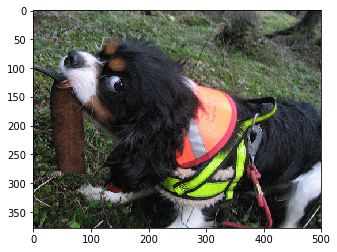

dog is running through the grass


In [11]:
model = load_model('vgg.h5')
images = 'Flickr8k_Dataset/Flicker8k_Dataset/'


with open("features.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)
    

def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

max_length = 34
image_index+=1
pic = list(encoding_test.keys())[image_index]
image = encoding_test[pic].reshape((1,4096))
x=plt.imread(images+pic + '.jpg')
plt.imshow(x)
plt.show()
print(greedySearch(image))